# Project Part 1

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/brearenee/NLP-Project/blob/main/startrek.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/https://github.com/brearenee/NLP-Project/blob/main/startrek.ipynb)


## 1. Introduction/Background
In this notebook, I'll be working with a dataset containing dialogue transcripts from various Star Trek series episodes, which I found on [kaggle](http://http://https://www.kaggle.com/datasets/birkoruzicka/startrekdialoguetranscripts/data). This dataset provides a large amount of script lines, each accompanied by information on episode, seriess, and the character who delivered said line. 

The objective of this project is to build a model capable of predicting the reoccuring character associated with a given line from the script from the series "The Next Generation".  This type of problem is known as Speaker Identification and i'll be treating it as a text classification problem since model will need to learn patterns that are indicative of the speaking style of each character. Since there are multiple different characters which occur in this dataset, the end result is a multi-class classification task. 











## 2. Data Preprocessing

The datasource I'm working with is initially structured as a highly nested JSON file, and it's original format isn't quite optimal for the model I'm trying to create.  It also includes a lot of data I don't necessarily need. Becase of this, I'll need to parse through the file and transform it's structure to allow for a more useful dataframe. As I'm only trying to predict lines from "The Next Generation", I'll also be removing the other series from my dataset. 



In [1]:
# import all of the python modules/packages you'll need here
import pandas as pd
import json
import requests
# ...

In [2]:
url = 'https://raw.githubusercontent.com/brearenee/NLP-Project/main/dataset/StarTrekDialogue.json'

# Make a GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Load JSON data from the response
    json_data = json.loads(response.text)

    # Extract lines, characters, episodes, and series
    lines = []
    characters = []
    episodes = []
  

    # extract the information from the JSON file for the "TNG" series
    for series_name, series_data in json_data.items():
        if series_name == "TNG":  # Only consider data from the "TNG" series
            for episode_name, episode_data in series_data.items():
                for character_name, character_lines in episode_data.items():
                    for line_text in character_lines:
                        lines.append(line_text)
                        characters.append(character_name)
                        episodes.append(episode_name)
                     

    # Create a DataFrame from the extracted data
    df = pd.DataFrame({
        'Line': lines,
        'Character': characters,
        'Episode': episodes,
    })

    # Remove duplicate lines, keeping the first occurrence (preserving the original order)
    df = df.drop_duplicates(subset='Line', keep='first')

    # Reset the index of the DataFrame
    df.reset_index(drop=True, inplace=True)

else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")


Lets take a look at all of the characters in this Star Trek series

In [3]:
unique_characters = df['Character'].unique().tolist()

# Display the list of unique characters
print(unique_characters)

['PICARD', 'DATA', 'TROI', 'TORRES', 'WORF', 'Q', 'TASHA', "O'BRIEN", 'BAILIFF', 'SOLDIER', 'ZORN', 'RIKER', 'WESLEY', 'CRUSHER', 'LAFORGE', 'MCCOY', 'ENSIGN', 'COMPUTER', 'SECURITY', 'CREW', 'WOMAN', 'MAN', 'CRUSHER:', 'SHIMODA', 'MACDOUGAL', 'CREWMAN', 'TROI: Bill.\r RIKER', 'LUTAN', 'HAGON', 'PICARD: Absolutely not. This vaccine sample is a gift of life and we\r are honoured at receiving it. Would you do us the additional honour of\r now letting us entertain you?\r LUTAN', 'YAREENA', 'CHIEF', 'TARR', 'LETEK', 'MORDOC', 'KAYRON', 'PORTAL', 'KOSINSKI', 'ARGYLE', 'TRAVELLER', 'MAMAN', 'WESLEY: Parts of him disappeared and then came back. Nobody else was\r paying attention to him the first time.\r RIKER', "WESLEY: No! He's very weak. TRAVELLER", 'SELAY', 'GEORDI', 'ANTICAN', 'SINGH', 'RIVAN', 'LIATOR', 'EDO', 'BOY', 'GIRL', 'OFFICER', 'MEDIATOR 2', 'MEDIATOR', 'BEVERLY', 'MEDIC', 'BOK', 'KAZAGO', 'RATA', 'VOICES', 'VOICE', 'FACE', 'STEVEN', 'VICTORIA', 'WYATT', 'LWAXANA', 'VALEDA', 'WRE

As you can see, this is pretty messy.  Not only does this series have a lot of one-episode characters, but there is quite a bit of mislabeled data.  Let's eliminate all of the outliers by removing characters that don't occur in more than 5 episodes. 

In [4]:
episode_counts = df.groupby('Character')['Episode'].nunique()

characters_to_keep = episode_counts[episode_counts > 5].index

df = df[df['Character'].isin(characters_to_keep)]
unique_characters = df['Character'].unique().tolist()


print(unique_characters)

['PICARD', 'DATA', 'TROI', 'WORF', 'Q', 'TASHA', "O'BRIEN", 'RIKER', 'WESLEY', 'CRUSHER', 'LAFORGE', 'COMPUTER', 'SECURITY', 'WOMAN', 'MAN', 'CREWMAN', 'CHIEF', 'MEDIC', 'VOICE', 'LWAXANA', 'CREWWOMAN', 'NURSE', 'GUINAN', 'PULASKI', 'ALL', 'OGAWA', 'KLINGON', 'ROMULAN', 'ALEXANDER', 'KEIKO', 'RO']


This result is a lot better, but there are still some fields in here like "ALL" "BOTH" or "GIRL" that dont correlate to one single character/species - lets check the distribution


In [5]:
character_counts = df['Character'].value_counts()
print(character_counts)

Character
PICARD       10785
RIKER         6452
DATA          5691
LAFORGE       4107
WORF          3183
CRUSHER       2941
TROI          2855
WESLEY        1204
Q              535
PULASKI        485
TASHA          473
COMPUTER       471
O'BRIEN        440
GUINAN         432
LWAXANA        404
RO             304
ALEXANDER      156
OGAWA          110
KEIKO           78
CREWMAN         51
WOMAN           46
NURSE           30
CHIEF           28
VOICE           27
ROMULAN         25
MAN             22
CREWWOMAN       17
SECURITY        15
KLINGON         14
ALL             13
MEDIC            6
Name: count, dtype: int64


As we can see, this is still a pretty uneven data set. I'd like to once again remove the outliers. We will do this by eliminating those characters with less than 1000 lines. 

In [6]:
character_counts = df['Character'].value_counts()


characters_to_remove = character_counts[character_counts < 1000].index
df = df[~df['Character'].isin(characters_to_remove)]


## 2. Exploratory Data Analysis

let's take a look at our dataframe!  Compared to the original JSON file, this is much cleaner. 

In [7]:
df.head(10)

,Line,Character,Episode
0,"You will agree, Data, that Starfleet's\r order...",PICARD,tng_000
1,As simple as that.,PICARD,tng_000
2,"It's hardly simple, Data, to negotiate a frien...",PICARD,tng_000
3,"Data, how can you be programmed as a virtual e...",PICARD,tng_000
4,"It means to spy, to sneak.",PICARD,tng_000
5,"Exactly, yes.",PICARD,tng_000
6,Shut off that damned noise. Go to Yellow Alert.,PICARD,tng_000
7,"Reverse power, full stop.",PICARD,tng_000
8,That's quite a directive. Would you mind ident...,PICARD,tng_000
9,"Data, call medics.",PICARD,tng_000


and lets take a look at our Character distribution now that we have removed the outliers

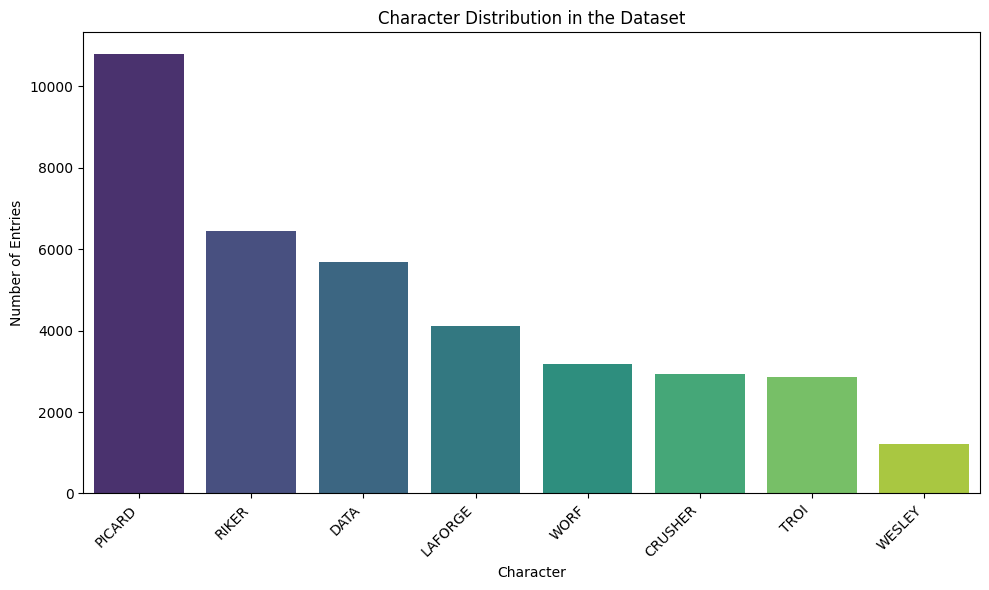

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


character_counts = df['Character'].value_counts()


plt.figure(figsize=(10, 6))
sns.barplot(x=character_counts.index, y=character_counts.values, palette="viridis")
plt.xlabel('Character')
plt.ylabel('Number of Entries')
plt.title('Character Distribution in the Dataset')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [9]:
print(character_counts)

Character
PICARD     10785
RIKER       6452
DATA        5691
LAFORGE     4107
WORF        3183
CRUSHER     2941
TROI        2855
WESLEY      1204
Name: count, dtype: int64


The dataset is still unbalanced, but at least the outliers are gone and we are only left with the top 8 main characters of the show.  

Now lets check the average line length

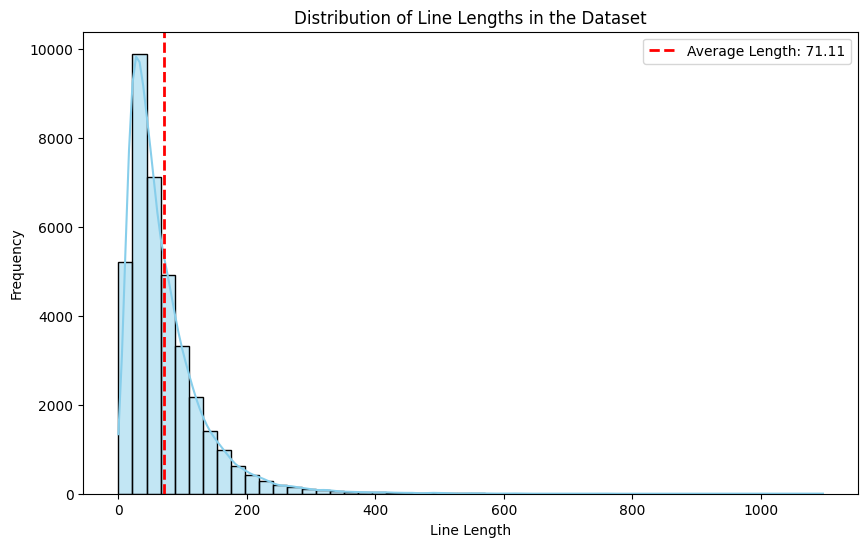

Average Line Length: 71.11 characters


In [10]:

df['Line_Length'] = df['Line'].apply(len)


average_line_length = df['Line_Length'].mean()


plt.figure(figsize=(10, 6))
sns.histplot(df['Line_Length'], bins=50, kde=True, color='skyblue')
plt.axvline(average_line_length, color='red', linestyle='dashed', linewidth=2, label=f'Average Length: {average_line_length:.2f}')
plt.xlabel('Line Length')
plt.ylabel('Frequency')
plt.title('Distribution of Line Lengths in the Dataset')
plt.legend()
plt.show()


print(f'Average Line Length: {average_line_length:.2f} characters')


In [11]:
long_lines = df[df['Line'].apply(len) > 800]

# Display the lines
print(long_lines)


                                                    Line Character  Episode  \
2086   Oh, they're already underway. I have an announ...    PICARD  tng_005   
4447   When you spoke of the prisoners, you used the ...     RIKER  tng_012   
12011  You see, he's met two of your three criteria f...    PICARD  tng_033   
31554  I am deeply concerned by what is happening her...    PICARD  tng_093   
31992  You know, Deanna, the first man I ever loved u...   CRUSHER  tng_095   
38854  You even sat in my chair. I was annoyed. Presu...    PICARD  tng_117   
55977  I understand your concerns, Lieutenant, and I ...    PICARD  tng_175   

       Line_Length  
2086           907  
4447           821  
12011         1097  
31554          850  
31992         1090  
38854          828  
55977          878  


Most of the lines are pretty short, but Picard, Ricker, and Crusher seem to give a couple of speeches here and there. 